<a href="https://colab.research.google.com/github/oksuzian/Mu2eANL/blob/master/Macros/Ana1stSteps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install kerberos

In [1]:
!apt-get install krb5-user

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  bind9-host geoip-database krb5-config libbind9-160 libdns1100 libgeoip1
  libgssrpc4 libisc169 libisccc160 libisccfg160 libkadm5clnt-mit11
  libkadm5srv-mit11 libkdb5-9 liblwres160
Suggested packages:
  geoip-bin krb5-doc
The following NEW packages will be installed:
  bind9-host geoip-database krb5-config krb5-user libbind9-160 libdns1100
  libgeoip1 libgssrpc4 libisc169 libisccc160 libisccfg160 libkadm5clnt-mit11
  libkadm5srv-mit11 libkdb5-9 liblwres160
0 upgraded, 15 newly installed, 0 to remove and 15 not upgraded.
Need to get 3,856 kB of archives.
After this operation, 15.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libisc169 amd64 1:9.11.3+dfsg-1ubuntu1.13 [238 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgeoip1 amd64 1.6.12-1 [71.8 kB]
Get:3 http:/

In [2]:
!wget https://authentication.fnal.gov/krb5conf/Linux/krb5.conf

--2020-12-30 23:08:19--  https://authentication.fnal.gov/krb5conf/Linux/krb5.conf
Resolving authentication.fnal.gov (authentication.fnal.gov)... 131.225.105.240, 2620:6a:0:105::105:240
Connecting to authentication.fnal.gov (authentication.fnal.gov)|131.225.105.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17486 (17K) [text/plain]
Saving to: ‘krb5.conf’

krb5.conf           100%[===================>]  17.08K  --.-KB/s    in 0.03s   

2020-12-30 23:08:19 (508 KB/s) - ‘krb5.conf’ saved [17486/17486]



In [3]:
import os
os.environ['KRB5_CONFIG'] = 'krb5.conf'

#Copy files from FNAL

In [4]:
!kinit oksuzian@FNAL.GOV

Password for oksuzian@FNAL.GOV: 


In [5]:
!scp -o StrictHostKeyChecking=no -o GSSAPIAuthentication=yes -o GSSAPIDelegateCredentials=yes oksuzian@mu2egpvm04.fnal.gov:/pnfs/mu2e/scratch/outstage/oksuzian/sim.mu2e.cosmic-g4s1-dsstops.dyb0520.root .
!scp -o StrictHostKeyChecking=no -o GSSAPIAuthentication=yes -o GSSAPIDelegateCredentials=yes oksuzian@mu2egpvm04.fnal.gov:/mu2e/data/users/oksuzian/sim.mu2e.cosmic-g4s1-dsstops.cry-rs1-0220-g4-10-5.root .

In [6]:
%pip install uproot

     |████████████████████████████████| 204kB 4.2MB/s 


In [7]:
import uproot
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from plotly import graph_objs as go
import pylab
import seaborn as sns
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.1f' % x)

In [8]:
DYB_CRV_file = uproot.open("sim.mu2e.cosmic-g4s1-dsstops.dyb0520.root")
DYB_CRV_tree = DYB_CRV_file["HitDumper"]["nt"]
CRY_CRV_file = uproot.open("sim.mu2e.cosmic-g4s1-dsstops.cry-rs1-0220-g4-10-5.root")
CRY_CRV_tree = CRY_CRV_file["HitDumper"]["nt"]

In [9]:
DYB_CRV_df = DYB_CRV_tree.arrays(library='pd')
DYB_CRV_df.columns = DYB_CRV_df.columns.droplevel()
CRY_CRV_df = CRY_CRV_tree.arrays(library='pd')
CRY_CRV_df.columns = CRY_CRV_df.columns.droplevel()

#Ana

In [19]:
def plot_comparision(var, df1, df2, ax, title):

    cry_secs=118.4
    dyb_secs=203.5

    range=(df1[var].min(),df1[var].max())
    if var=='ek' or var=='pmag' or var=='time':
      range=(0,20000)
    if var=='InitX' or var=='InitZ' or var=='px' or var=='py' or var=='pz':
      range=(-200000,200000)

    weights = np.ones_like(df1[var]) / dyb_secs
    counts, bins, _ = ax.hist(df1[var], bins=100, histtype='step', range=range, label='DYB', weights=weights)
    area = sum(np.diff(bins)*counts)
    ax.text(1.01,0.7, 
            'DYB\n'+df1[var].describe().loc[['count','mean','std']].to_string()+'\nintegral '+'%.1f' % counts.sum(),
            transform=ax.transAxes,
            bbox=dict(facecolor='blue', alpha=0.15))



    weights = np.ones_like(df2[var]) / cry_secs
    counts, bins, _ = ax.hist(df2[var], bins=bins, histtype='step', range=range, label='CRY', weights=weights)
    area = sum(np.diff(bins)*counts)
    ax.text(1.01,0.4, 
            'CRY\n'+df2[var].describe().loc[['count','mean','std']].to_string()+'\nintegral '+'%.1f' % counts.sum(), 
            transform=ax.transAxes,
            bbox=dict(facecolor='orange', alpha=0.15))
    ax.set_xlabel(var)
    ax.set_title(title)
    ax.set_xlim(bins[0], bins[-1])
    ax.legend(loc='best')
    ax.set_yscale('log')

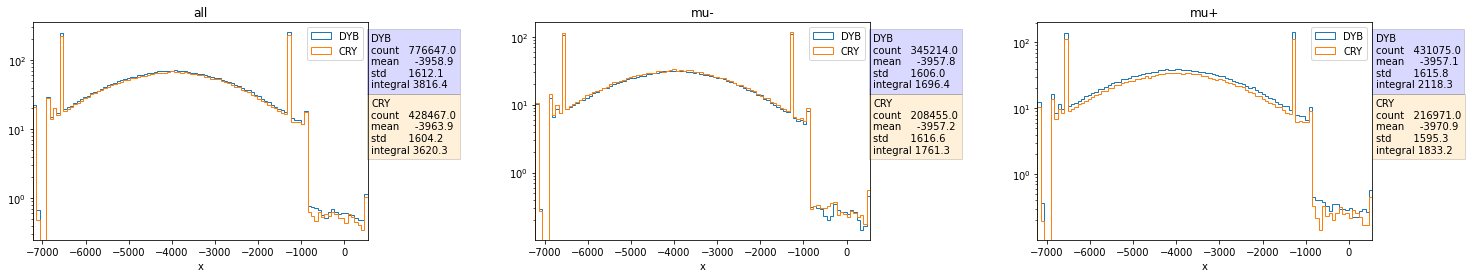

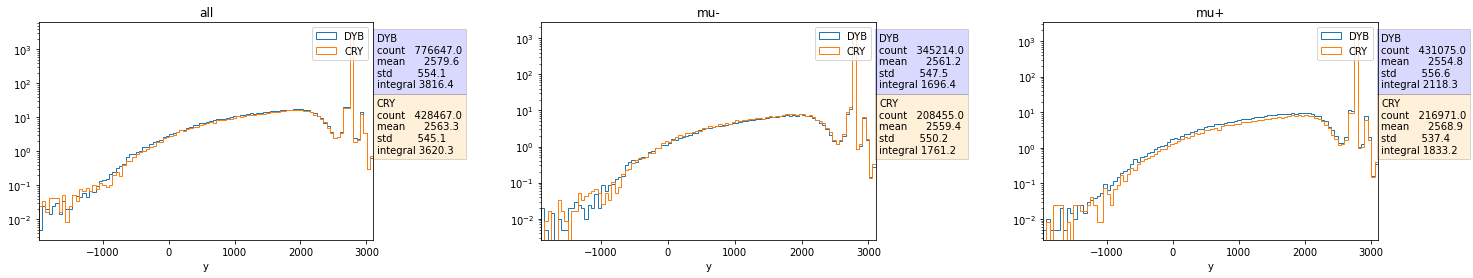

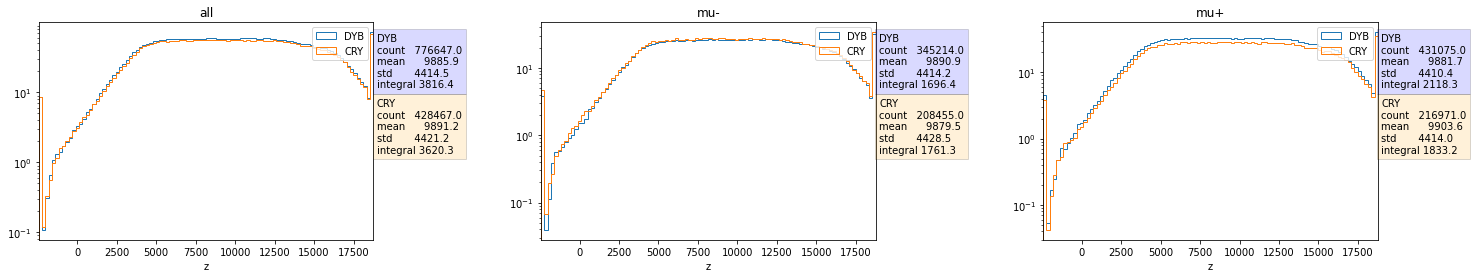

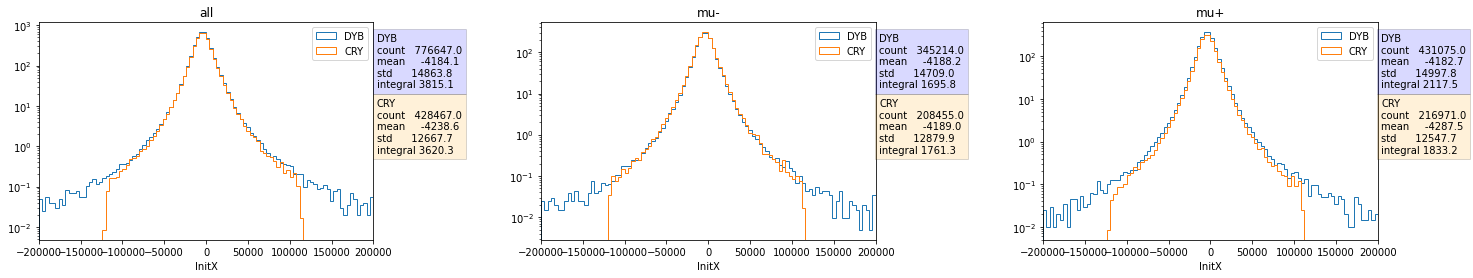

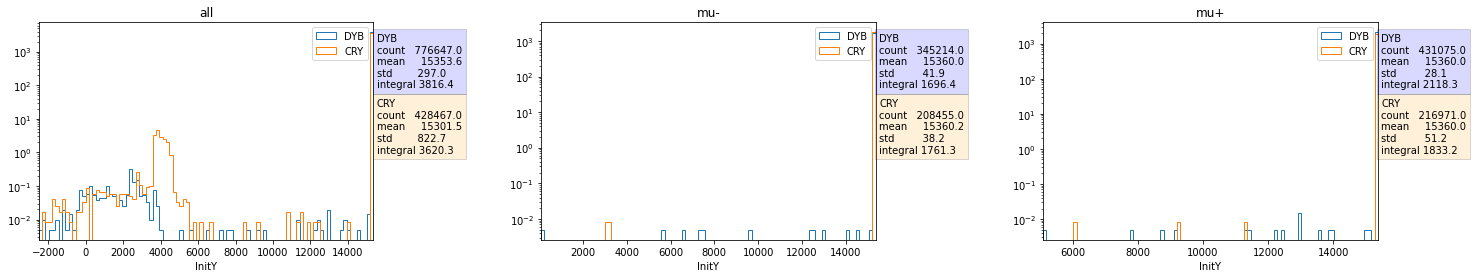

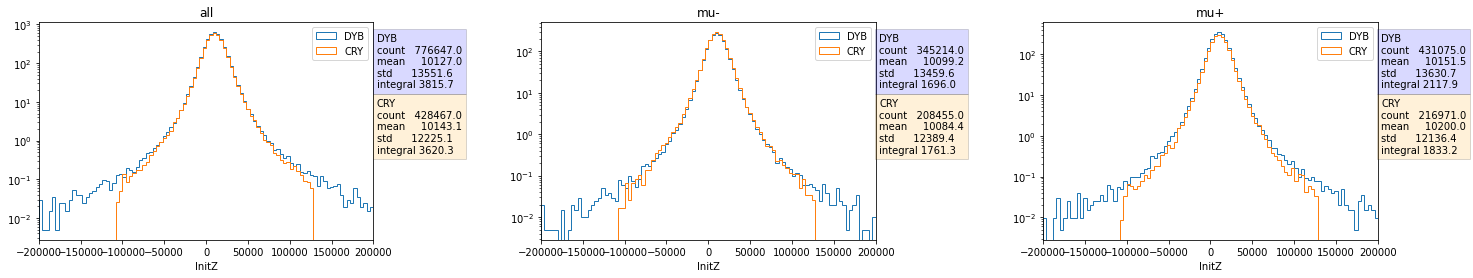

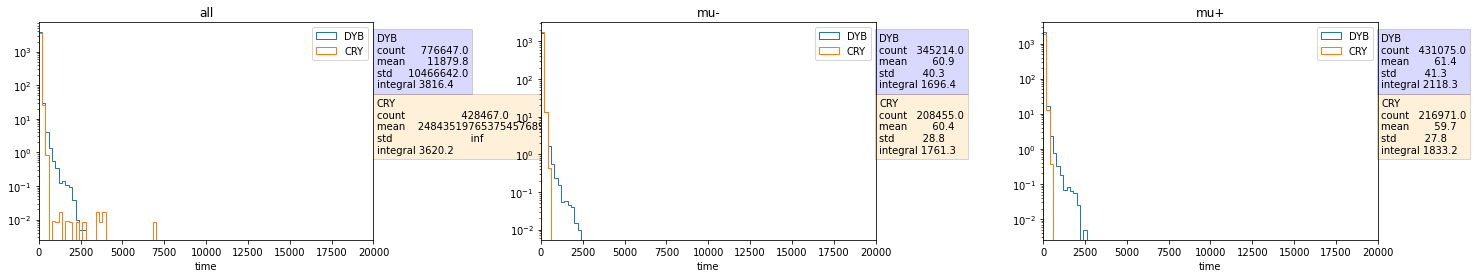

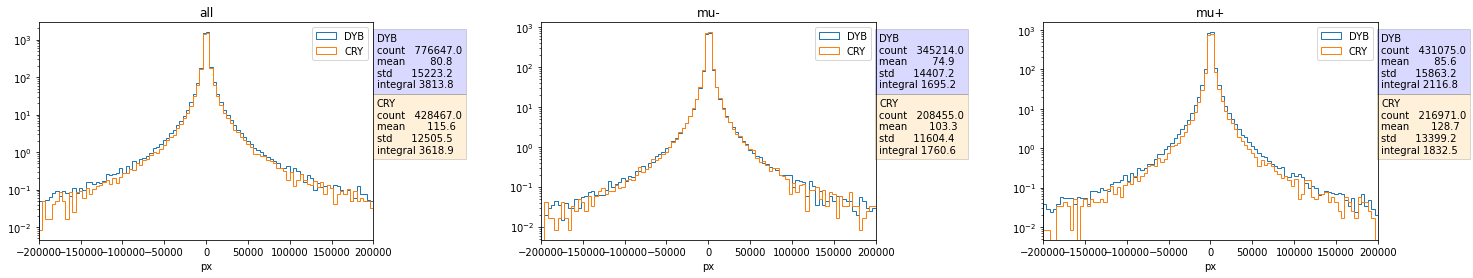

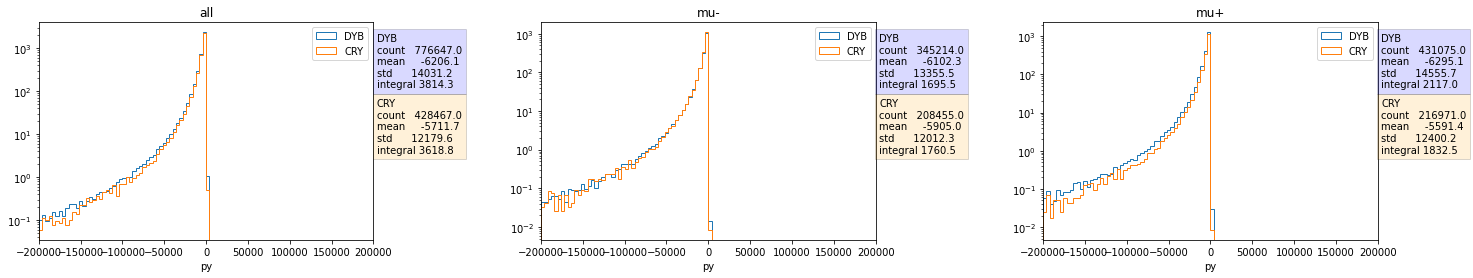

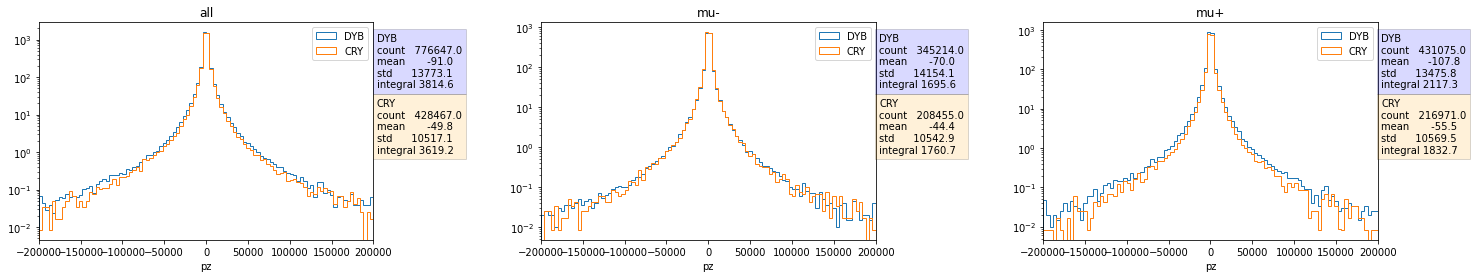

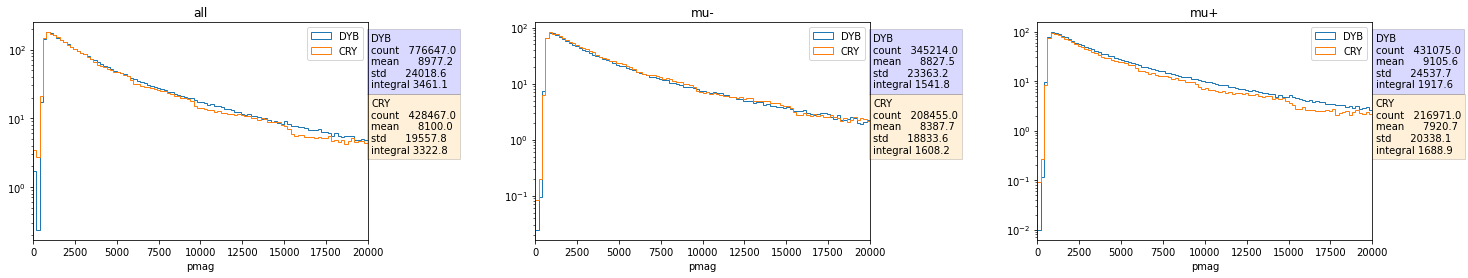

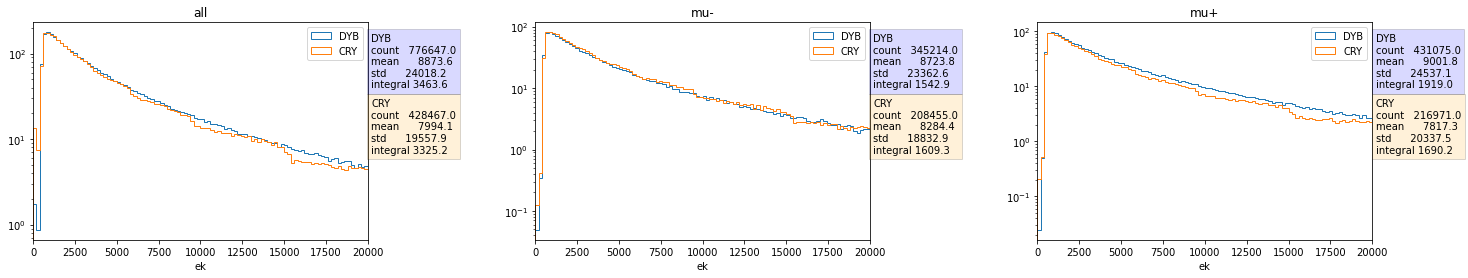

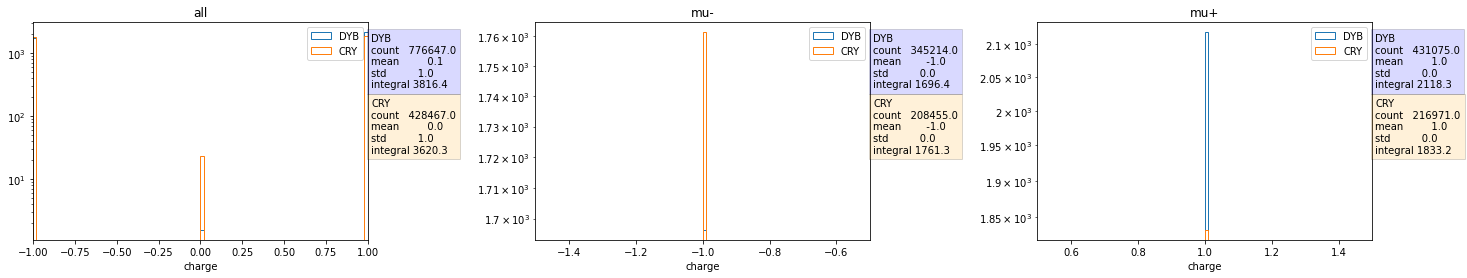

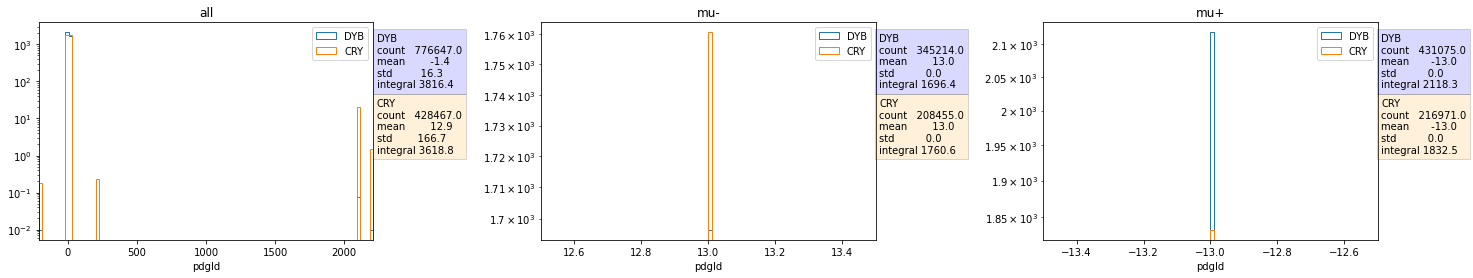

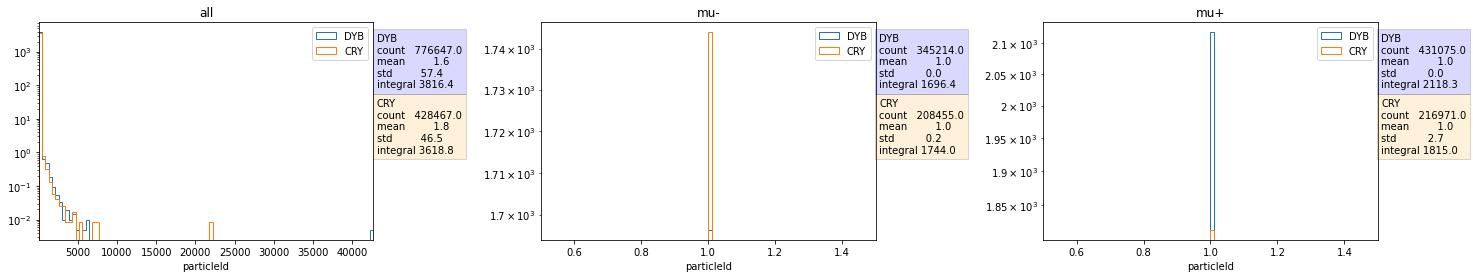

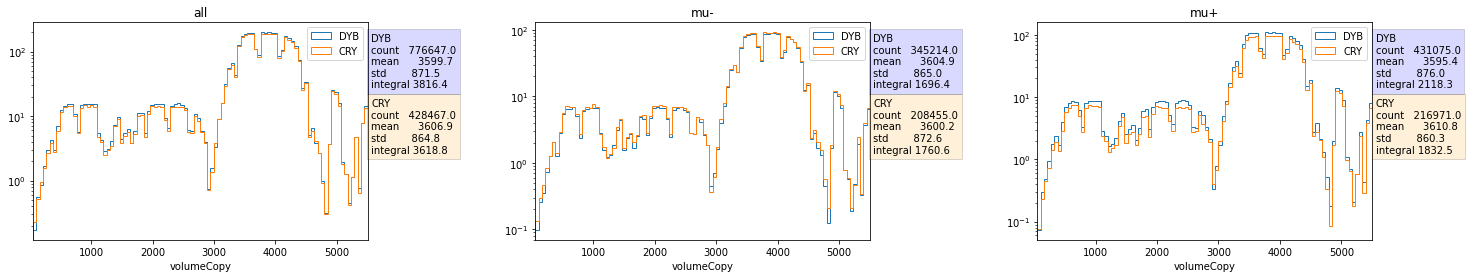

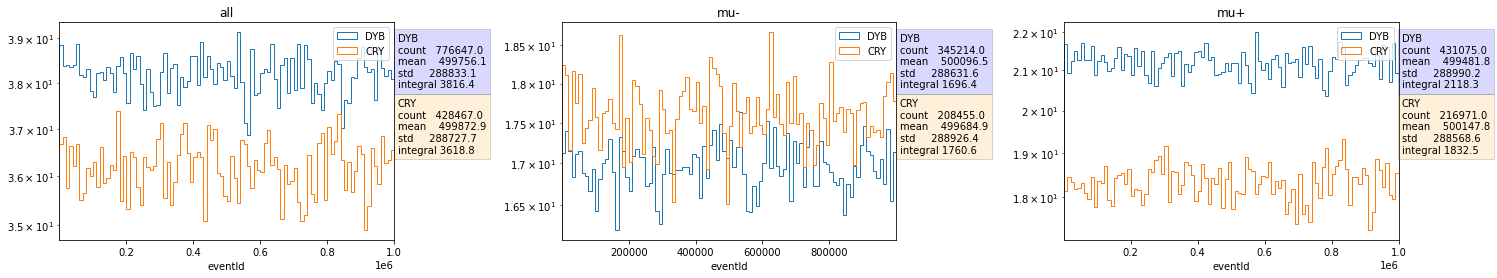

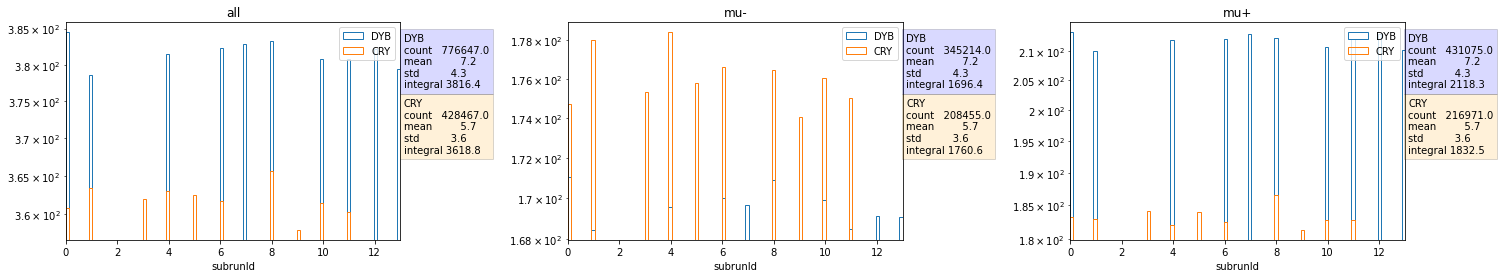

In [20]:
for var in DYB_CRV_df.columns:
  fig, ax = plt.subplots(1, 3, figsize=(24,4))
  fig.subplots_adjust(wspace=0.5)
  plot_comparision(var, DYB_CRV_df, CRY_CRV_df, ax[0], 'all')
  plot_comparision(var, DYB_CRV_df.query('pdgId == 13'), CRY_CRV_df.query('pdgId == 13'), ax[1], 'mu-')
  plot_comparision(var, DYB_CRV_df.query('pdgId == -13'), CRY_CRV_df.query('pdgId == -13'), ax[2], 'mu+')